In [1]:
import sys
sys.path.append("../code")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scale_bar import add_scalebar
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']

from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from sklearn.datasets import make_moons

from scipy.spatial import procrustes

dataset = 2
import mnist_reader 
    
X_train, y_train = mnist_reader.load_mnist('../data/mnist', kind='train')
X_test, y_test = mnist_reader.load_mnist('../data/mnist', kind='t10k')

X_train = X_train.astype(np.float32)
max_val = np.max(X_train)
X_train = X_train/max_val

X_test = X_test/max_val

n = X_train.shape[0]

classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9']

print(X_train.shape, y_train.shape, X_train.dtype)

#Torch Setups
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
x_init = pca.fit_transform(X_train)
x_init = x_init - np.mean(x_init, axis=0)

def print_stats(X):
    print('size: ', X.shape)
    print('Mean:', np.mean(X))
    print('Max: ', np.max(X))
    print('Min: ', np.min(X))
    print('STD: ', np.std(X))
    
    return

print('Training Statistics')
print_stats(X_train)
#print('Test Statistics')
#print_stats(X_test)


epochs = 200
n_neighbors= 15
n_components = 2
MIN_DIST = 0.1

    
%matplotlib notebook
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(60000, 784) (60000,) float32
Training Statistics
size:  (60000, 784)
Mean: 0.13066062
Max:  1.0
Min:  0.0
STD:  0.30810776


In [2]:
from scale_bar import add_scalebar
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from matplotlib.offsetbox import HPacker, TextArea

def plot_idxs(array,idxs,title=None, values = None, tick_off=True):
    
    plt.figure()
    
    if title is not None:
        plt.title(title)
        
    n_plot = int(np.sqrt(len(idxs)))
    
    for i in range(n_plot**2):
        ax = plt.subplot(n_plot, n_plot, i+1)
        plt.scatter(array[idxs[i],:,0], array[idxs[i],:,1], c=y_train, s=0.01, cmap='Spectral')
        add_scalebar(ax, loc=4, barwidth=1, matchx=False, matchy=False, 
                     sizey=1, sizex=1, 
                     labelx='1.0', labely='1.0',
                    fontsize='xx-small',
                    hidex=True, hidey=True)
        
        
        if values is not None:
            val = r"$p_d=${:.3f}".format(values[i])
            plt.text(1.0, 1.0, val,
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        if tick_off:
            plt.xticks([])
            plt.yticks([])
        plt.axis('on')
        
    return

def plot_low_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, k)[:k]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def plot_high_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, -k)[-k:]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def my_procrustes(data1, data2):
    #adapted from https://github.com/scipy/scipy/blob/v1.11.2/scipy/spatial/_procrustes.py#L15-L131
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)
    
    
    mtx1 -= np.mean(mtx1, 0)
    mtx2 -= np.mean(mtx2, 0)

    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)
    
    mtx1 /= norm1
    mtx2 /= norm2
    
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s
    
    disparity = np.sum(np.square(mtx1 - mtx2))
    
    mtx2 = np.dot(data2, R.T) #just get the rotation, reflection - and no scaling
    
    
    return disparity, mtx2

def procrustes_distances(standard_array, array, verbose=True): 
    pds = []
    X_pdx = []

    for i in range(len(array)):
        d,x_pd = my_procrustes(standard_array, array[i])
        pds.append(d)
        X_pdx.append(x_pd)

    pds = np.array(pds)
    X_pdx = np.array(X_pdx)
    if verbose:
        print('Procrusted Distance: Mean: ', np.mean(pds), ' STD: ', np.std(pds))
    
    return pds, X_pdx

def procrustes_matrix(standard_array, array):
    diagonal, X_pdx = procrustes_distances(standard_array, array)
    
    N = len(array)
    pd_mat = np.zeros((N,N))
    
    for i in range(N):
        row, _ = procrustes_distances(array[i], array, verbose=False)
        pd_mat[i,:] = row
    
    #print(np.diag(pd_mat))
    
    for i in range(N):
        pd_mat[i,i] = diagonal[i]
        
    return pd_mat, X_pdx

In [3]:
fname = 'random_init_test_orig'

with open('random_init_test_orig/mnist_PCA_init.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

(60000, 2)


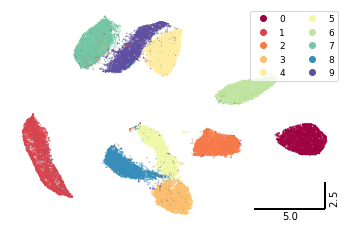

In [4]:
fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)

lgd = plt.legend(*scatter.legend_elements(),
                    loc="upper right",
                    fontsize=20,
                 ncol=2,
                prop={'size': 9})
for j in range(len(lgd.get_texts())):
    lgd.get_texts()[j].set_text(classes[j])
    
plt.savefig('fig_random/standard_minst_candle.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

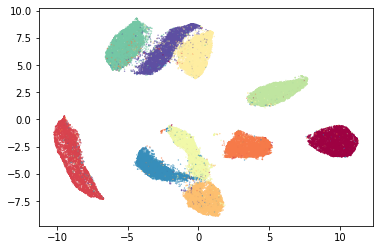

In [5]:
fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')

    
plt.savefig('fig_job_talk/standard_minst_candle.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

<h1>Original UMAP</h1>

In [6]:
with open(fname+'/mnist_random_init.npy', 'rb') as f:
    umap_r1 = np.load(f)
    
print(umap_r1.shape)

pd_r1, umap_pd_r1 = procrustes_distances(umap_pca, umap_r1)

print(umap_pd_r1.shape)

pd_mat, X_pdx = procrustes_matrix(umap_pca, umap_r1)

(100, 60000, 2)
Procrusted Distance: Mean:  0.7053622647092926  STD:  0.15559942723751405
(100, 60000, 2)
Procrusted Distance: Mean:  0.7053622647092926  STD:  0.15559942723751405


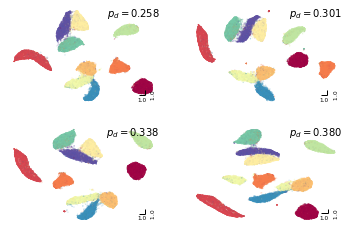

In [7]:
plot_low_k_idxs(umap_pd_r1,pd_r1,4)
plt.savefig('fig_random/umap_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

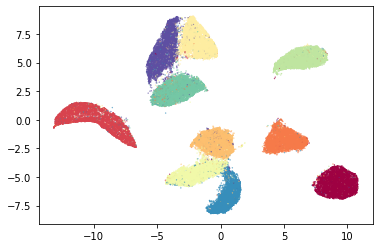

In [8]:
umap_r = umap_pd_r1[np.argsort(pd_r1)[0]]

fig, ax = plt.subplots()

scatter = plt.scatter(umap_r[:,0], umap_r[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')

[0.257765   0.3007015  0.33793958 0.38026451 0.40232562 0.4031186
 0.40398662 0.41879404 0.46639906 0.50526565 0.51360144 0.51607866
 0.52550328 0.54042881 0.5470094  0.56091289 0.5860181  0.59058729
 0.59079244 0.59141103 0.59420896 0.598487   0.59912341 0.61452486
 0.6181427  0.62288799 0.62379641 0.62958014 0.63366701 0.63448184
 0.63672123 0.64281756 0.64498629 0.64857596 0.6525695  0.65351586
 0.67453571 0.67645349 0.67682517 0.67970184 0.68153152 0.68520359
 0.68549599 0.6856348  0.68566433 0.69262352 0.69318923 0.7009301
 0.7083718  0.71006477 0.71286818 0.71423242 0.716174   0.71817547
 0.72217828 0.72222633 0.72946928 0.73064509 0.73451954 0.74052438
 0.74473368 0.75898135 0.76027175 0.7620768  0.77080203 0.79225754
 0.7967866  0.79798304 0.80346559 0.80535061 0.81482704 0.81531474
 0.82939767 0.8313611  0.83438934 0.83468817 0.84007911 0.84123789
 0.84177251 0.84285027 0.85358259 0.86046046 0.86691712 0.87223621
 0.87317106 0.87635959 0.88166452 0.88767896 0.89608198 0.900768

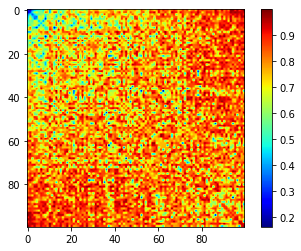

In [9]:
idx = np.argsort(np.diag(pd_mat))
pd_mat_2 = pd_mat[idx,:][:,idx]

plt.figure()
plt.imshow(pd_mat_2, cmap='jet')
plt.colorbar()

print(np.diag(pd_mat_2))

<h1>Modified Method</h1>

In [10]:
with open(fname+'/mnist_random_init_model_1_0.5v2.npy', 'rb') as f:
    umap_mod = np.load(f)
    
print(umap_mod.shape)

pd_mod, umap_pd_mod = procrustes_distances(umap_pca, umap_mod)

print(umap_pd_mod.shape)

pd_mat_mod, X_pdx_mod = procrustes_matrix(umap_pca, umap_mod)

(100, 60000, 2)
Procrusted Distance: Mean:  0.4817504093328434  STD:  0.17173666155171735
(100, 60000, 2)
Procrusted Distance: Mean:  0.4817504093328434  STD:  0.17173666155171735


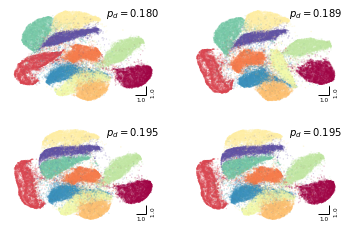

In [11]:
plot_low_k_idxs(umap_pd_mod,pd_mod,4)

plt.savefig('fig_random/umap_mod_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

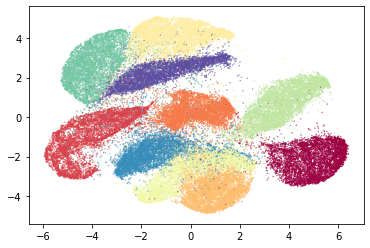

In [12]:
umap_m = umap_pd_mod[np.argsort(pd_mod)[0]]

fig, ax = plt.subplots()

scatter = plt.scatter(umap_m[:,0], umap_m[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')

    
plt.savefig('fig_job_talk/mnist_Modified.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

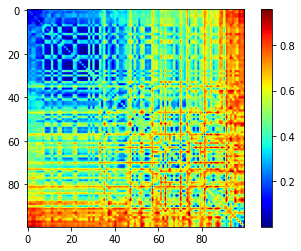

In [13]:
idx_mod = np.argsort(np.diag(pd_mat_mod))
pd_mat_2_mod = pd_mat_mod[idx_mod,:][:,idx_mod]

plt.figure()
plt.imshow(pd_mat_2_mod, cmap='jet')
plt.colorbar()

<h1>Composite Mod</h1>

In [14]:
with open(fname+'/mnist_random_init_model_1_composite_v2.npy', 'rb') as f:
    umap_com = np.load(f)
    
print(umap_com.shape)

pd_com, umap_pd_com = procrustes_distances(umap_pca, umap_com)

print(umap_pd_com.shape)

pd_mat_com, X_pdx_com = procrustes_matrix(umap_pca, umap_com)

(100, 60000, 2)
Procrusted Distance: Mean:  0.4871491202435198  STD:  0.17344057667916296
(100, 60000, 2)
Procrusted Distance: Mean:  0.4871491202435198  STD:  0.17344057667916296


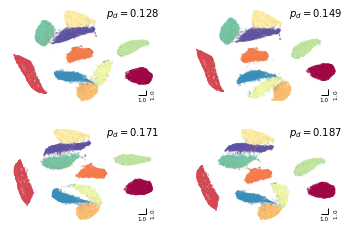

In [15]:
plot_low_k_idxs(umap_pd_com,pd_com,4)

plt.savefig('fig_random/umap_com_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

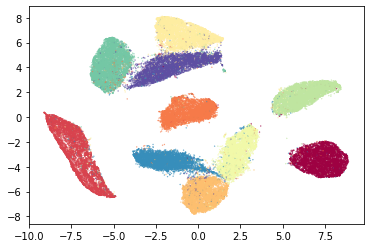

In [16]:
umap_c = umap_pd_com[np.argsort(pd_com)[0]]

fig, ax = plt.subplots()

scatter = plt.scatter(umap_c[:,0], umap_c[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')

    
plt.savefig('fig_job_talk/mnist_composite.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

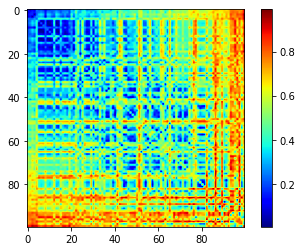

In [17]:
idx_com = np.argsort(np.diag(pd_mat_com))
pd_mat_2_com = pd_mat_com[idx_com,:][:,idx_com]

plt.figure()
plt.imshow(pd_mat_2_com, cmap='jet')
plt.colorbar()

In [18]:
min_val = np.floor(np.min(np.concatenate((pd_mat_2,pd_mat_2_mod,pd_mat_2_com))))
max_val = np.ceil(np.max(np.concatenate((pd_mat_2,pd_mat_2_mod,pd_mat_2_com))))

In [19]:
cmap = plt.cm.jet
norm = plt.Normalize(vmin=min_val, vmax=max_val)

pd_mat_2_image = cmap(norm(pd_mat_2))

print(pd_mat_2_image.shape)

plt.imsave('fig_random/umap_random_pdmat.eps', pd_mat_2_image, dpi=300)

pd_mat_2_mod_image = cmap(norm(pd_mat_2_mod))
plt.imsave('fig_random/umap_mod_random_pdmat.eps', pd_mat_2_mod_image, dpi=300)

pd_mat_2_com_image = cmap(norm(pd_mat_2_com))
plt.imsave('fig_random/umap_com_random_pdmat.eps', pd_mat_2_com_image, dpi=300)


(100, 100, 4)


In [20]:
pd_mat_3 = pd_mat_2.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Original UMAP: ', np.mean(z), np.std(z))

pd_mat_3 = pd_mat_2_mod.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Modified UMAP:', np.mean(z), np.std(z))

pd_mat_3 = pd_mat_2_com.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Composite UMAP: ', np.mean(z), np.std(z))


Original UMAP:  0.781400738893944 0.13470219375013448
Modified UMAP: 0.48524505339336244 0.20835271989512388
Composite UMAP:  0.5008188213845466 0.20142121957119488


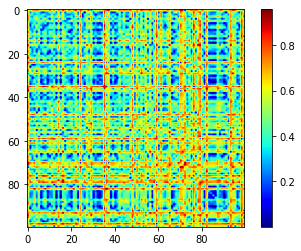

In [21]:
np.random.seed(23342)
idx_mod_2 = np.random.permutation(np.arange(100, dtype=np.int)) #np.argsort(np.diag(pd_mat_mod))
pd_mat_2_mod_orig = pd_mat_mod[idx_mod_2,:][:,idx_mod_2]

plt.figure()
plt.imshow(pd_mat_2_mod_orig, cmap='jet')
plt.colorbar()

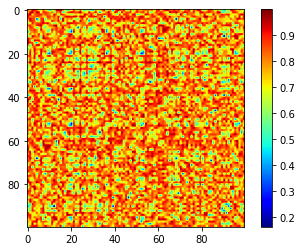

In [22]:
np.random.seed(23342)
idx_mod_2 = np.random.permutation(np.arange(100, dtype=np.int)) #np.argsort(np.diag(pd_mat_mod))
pd_mat_2_orig = pd_mat[idx_mod_2,:][:,idx_mod_2]

plt.figure()
plt.imshow(pd_mat_2_orig, cmap='jet')
plt.colorbar()

In [23]:
pd_mat_2_mod_image = cmap(norm(pd_mat_2_mod_orig))
plt.imsave('fig_random/umap_mod_random_pdmat_random.eps', pd_mat_2_mod_image, dpi=300)

pd_mat_2_mod_image = cmap(norm(pd_mat_2_orig))
plt.imsave('fig_random/umap_random_pdmat_random.eps', pd_mat_2_mod_image, dpi=300)



<h1>Colorbar</h1>

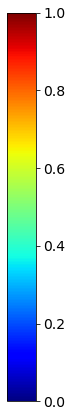

In [24]:
import pylab as pl
import numpy as np

a = np.array([[min_val,max_val]])
pl.figure(figsize=(0.5, 9))
img = pl.imshow(a, cmap="jet")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cb = pl.colorbar(orientation="vertical", cax=cax)
#pl.savefig("colorbar.pdf")
cb.ax.tick_params(labelsize=14)
pl.savefig("fig_random/colorbar.svg", dpi=400, bbox_inches='tight')

In [25]:
print(min_val)

print(max_val)

0.0
1.0
